In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib2tikz
import matplotlib.patches as mpatches


In [4]:

# Simple debugger

def debugger(list_of_variables, list_of_variable_names):

    for i in range(len(list_of_variables)):

        variable_value = list_of_variables[i]
        variable_name = list_of_variable_names[i]

        print(f'Variable name:{variable_name}, Value:{variable_value}')

In [5]:

# Defining Malfliet-Tjon potential

def potential_V(r):
    
    # Realistik nukleon-nukleon potential of Malfliet-Tjon type.
    # Ref: R. A. Malfliet and J.A. Tjon
    # Nuclear Physics A127 (1969) 161-168
    
    # input: Radius r in 10^-15 m or 1 fm 
    # Output: Potential V in MeV
    
    l_1 = -586.04
    l_2 = 1458.19
    l_3 = -872.15
    
    mu_1 = 1.55
    mu_2 = 3.11
    mu_3 = 6.00
    
    V_1 = l_1*np.exp(-mu_1*r)
    V_2 = l_2*np.exp(-mu_2*r)
    V_3 = l_3*np.exp(-mu_3*r)
    
    V = (V_1+V_2+V_3)/r
    
    return V


In [6]:

# Populating Vr vector
def populate_Vr(Vr, r):
    
    for i in range(Vr.size):
    
        Vr[i] = potential_V(r[i])

    return Vr


In [7]:

# Populating F function vector
def populate_Fvec(Fvec, Vr, E):
    
    # Mass of protron in MeV/c^2
    mass_protron = 938.272
    # Mass of neutron in MeV/c^2
    mass_neutron = 939.565
    # Reduced mass of the deutron
    my = (mass_protron*mass_neutron) / (mass_protron+mass_neutron)
    # hbar*c = 197.327 MeV*fm
    hbar = 197.327
    # The c cancels out from the MeV/c^2 unit of my
    K = 2 * my / hbar**2
    
    
    for i in range(Fvec.size):
    
        Fvec[i] = K*(Vr[i]-E)
    
    return Fvec
    

In [8]:

# Numerovs algorithm (Forward/Outer)

def numerov_outer(u, Fvec, u_0, u_1, index, steplength):

    # Init outward wave function
    u[0] = u_0
    u[1] = u_1
    h = steplength
    # Numerov outward
    for i in range(1, index):

        numerov_numerator = u[i] * (2 + (5 / 6) * (h ** 2) * Fvec[i]) - u[i - 1] * (1 - (1 / 12) * (h ** 2) * Fvec[i - 1])
        numerov_denominator = (1 - (1 / 12) * (h ** 2) * Fvec[i + 1])
        next_step = numerov_numerator / numerov_denominator
        u[i + 1] = next_step

    return u


In [9]:

# Numerovs algorithm (Backward/Inner)

def numerov_inner(u, Fvec, u_0, u_1, index, steplength):

    # Grabbing N from u to keep track of index better
    N = u.size
    # Init inward wave function
    u[N-1] = u_0
    u[N-2] = u_1
    h = steplength
    # Numerov inward
    for i in range(N-2, index-1, -1):
        
        numerov_numerator = u[i] * (2 + (5 / 6) * (h ** 2) * Fvec[i]) - u[i+1]* (1 - (1 / 12) * (h ** 2) * Fvec[i+1])
        numerov_denominator = (1 - (1 / 12) * (h ** 2) * Fvec[i-1])
        next_step = numerov_numerator / numerov_denominator
        u[i-1] = next_step

    return u

In [10]:

# Calculating wave function u(r)

def calc_u(E_values, vectors, iter_variables, rmp_index, df):
    
    # Unpacking variables
    Emin = E_values[0]
    Emax = E_values[1]
    E = 0.5 * (Emin+Emax)
    
    Vr = vectors[0]
    u = vectors[1]
    
    max_iter = iter_variables[0]
    continuity_tolerance = iter_variables[1]
    
    for iter in range(max_iter):


        # Init Fvec(r)
        # This vector is dependent on E
        Fvec = populate_Fvec(np.zeros(N), Vr, E)
    
        # Init outward integrated wave function
        u_outer = numerov_outer(np.zeros(N), Fvec, 0, h ** 1, rmp_index, h)
        u_out_mp = u_outer[rmp_index]
        df['u_outer'] = u_outer
    
        # Init inward integrated wave function
        #u_inner = numerov(np.zeros(N), Fvec, 0, h ** 1, (N - rmp_index - 2), h, revese=True)
        u_inner = numerov_inner(np.zeros(N), Fvec, 0, h ** 1, rmp_index+2, h)
        u_in_mp = u_inner[rmp_index + 2]
        df['u_inner'] = u_inner
    
        # Scaling factor between ingoing and outgoing wave function
        scale_factor = u_out_mp / u_in_mp
    
        # Match the height and create the full vector u
        u = u_outer + scale_factor * u_inner
    
        df['u'] = u
    
        # Calculate the discontinuity of the derivative of mp
        dx = np.gradient(u, h)
        df['dx'] = dx
        u_outer_dx = dx[rmp_index]
        u_inner_dx = dx[rmp_index + 1]
        matching = (u_inner_dx - u_outer_dx)
    
    
        if abs(matching) < continuity_tolerance:
            # Break the loop
            print('Continuity tolerance achieved!')
            break
    
        if u[rmp_index] * matching > 0:
            Emax = E
    
        if u[rmp_index] * matching < 0:
            Emin = E
    
        # Calculating E for the next iteration.
        E = 0.5 * (Emax + Emin)

    # Returning function u, bounding energy E and dataframe df for debugging purpose
    return [u, E, df]


------------ Starting run ------------
----------- with parameters ----------
Variable name:r_max in fm, Value:20.0
Variable name:N, Value:20000
Variable name:h, Value:0.001
Variable name:Emin in MeV, Value:-69.53667143456794
Variable name:Emax in MeV, Value:0.0
Variable name:Maximum iterations, Value:1000
Variable name:Continuity tolerance, Value:1e-10
Variable name:rmp_index, Value:1000
Continuity tolerance achieved!
------------- Ending run -------------

-------------- Results ---------------
Bounding energy in MeV, E = -2.22778042914117
Radius in fm, r_d = 1.945285349027254


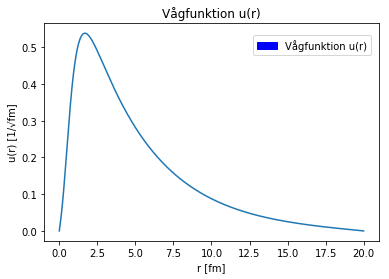

In [29]:

# Declaring constants

# Grid in fm
r_max = 20.0
# Number of steps
N = 20000
# Step lengt
h = r_max / N

# Init grid and potential V(r) for every r
# OBS: Never use 0
r = np.linspace(10.**-16, r_max, num=N)
Vr = populate_Vr(np.zeros(N), r)
u = np.zeros(N)

# Init dataframe to debug indexing if necessary
df = pd.DataFrame()

# Set important parameters
Emin = min(Vr)
Emax = 0.0
E_values = [Emin, Emax]
max_iter = 1000
continuity_tolerance = 0.0000000001
rmp_index = 1000

print('------------ Starting run ------------')
print('----------- with parameters ----------')
run_settings = [r_max, N, h, Emin, Emax, max_iter, continuity_tolerance, rmp_index]
debugger(run_settings, ['r_max in fm', 'N', 'h', 'Emin in MeV', 'Emax in MeV', 
    'Maximum iterations', 'Continuity tolerance', 'rmp_index'])

# Calculate u and E with corresonding df
results = calc_u([Emin, Emax], [Vr, u], [max_iter, continuity_tolerance], rmp_index, df)
print('------------- Ending run -------------')
print()

# Grabbing the results
u = results[0]
E = results[1]
df = results[2]

print('-------------- Results ---------------')
# Normalize the function so that the integral of u(r)^2 = 1
u_norm = u / np.linalg.norm(u)
# Calculate the value for r_d
r_d = np.sqrt(np.trapz(u_norm*u_norm*r*r) / 4)
print(f'Bounding energy in MeV, E = {E}')
print(f'Radius in fm, r_d = {r_d}')

# Plotting the function
plt.plot(r, u_norm*(0.54/0.0170))
plt.title('Vågfunktion u(r)')
plt.xlabel('r [fm]')
plt.ylabel('u(r) [1/√fm]')

blue_patch = mpatches.Patch(color='blue', label='Vågfunktion u(r)')
plt.legend(handles=[blue_patch],bbox_to_anchor=(0.8, 0.9), loc='center', ncol=1)


#plt.show()

matplotlib2tikz.save('u_r.tikz')


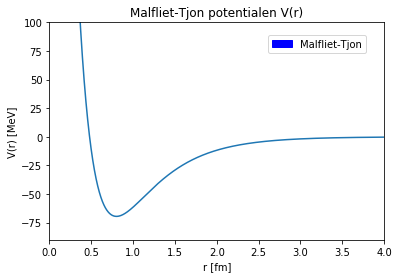

In [30]:

# Plotting the function
plt.plot(r, Vr)
plt.axis([0, 4, -90, 100])
plt.title('Malfliet-Tjon potentialen V(r)')
plt.xlabel('r [fm]')
plt.ylabel('V(r) [MeV]')

blue_patch = mpatches.Patch(color='blue', label='Malfliet-Tjon')
plt.legend(handles=[blue_patch],bbox_to_anchor=(0.8, 0.9), loc='center', ncol=1)

#plt.show()

matplotlib2tikz.save('V_r.tikz')